# Video Segmentation Data

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

load the embedded video data

In [2]:
Z = np.load('data/videodata/video_color_Z_embedded_64.npy')

# the "Sax" movie is from time slices 0 to 5537
sax = Z[0:5537, :]

In [ ]:
# # plot a 2-D representation of the video dynamics through time

# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, init='random', random_state=0, perplexity=50)
# sax_tsne = tsne.fit_transform(sax)


# plt.figure(figsize=(5, 5))
# plt.plot(sax_tsne[:, 0], sax_tsne[:, 1])

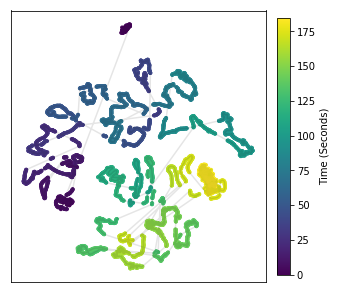

In [4]:
# t = np.arange(np.shape(sax)[0], dtype='float') / 30.0
# plt.figure(figsize=(5, 5))
# plt.plot(sax_tsne[:, 0], sax_tsne[:, 1], color='k', alpha=0.1)
# sc = plt.scatter(sax_tsne[:, 0], sax_tsne[:, 1], c=t, marker='.')

# cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
# cbar.set_label('Time (Seconds)')

# plt.xticks([])
# plt.yticks([])
# plt.show()

([], <a list of 0 Text yticklabel objects>)

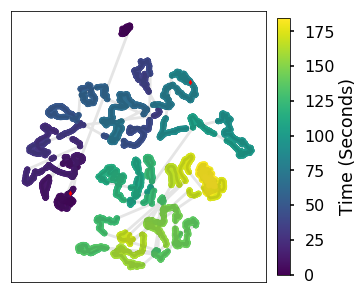

In [5]:
# sns.set_context('poster')
# t = np.arange(np.shape(sax)[0], dtype='float') / 30.0
# plt.figure(figsize=(5, 5))
# plt.plot(sax_tsne[:, 0], sax_tsne[:, 1], color='k', alpha=0.1)
# sc = plt.scatter(sax_tsne[:, 0], sax_tsne[:, 1], c=t, marker='.')

# plt.plot(sax_tsne[225,  0], sax_tsne[225, 1], c='r', marker='d', markersize=4)
# plt.plot(sax_tsne[2500, 0], sax_tsne[2500, 1], c='r', marker='d', markersize=4)
# # plt.plot(sax_tsne[5000, 0], sax_tsne[5000, 1], c='k', marker='d')



# cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
# cbar.set_label('Time (Seconds)')

# plt.xticks([])
# plt.yticks([])
# # plt.show()
# # plt.savefig('sax_tSNE.png', dpi=300, bbox_inches='tight')

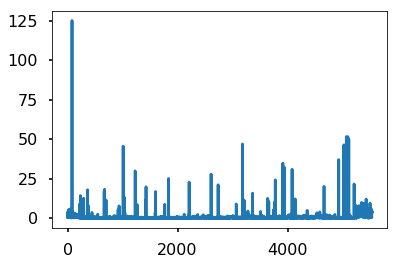

In [6]:
# # get the absolute movement in tSNE space
# movement = np.sqrt(np.sum((sax_tsne[1:, :] - sax_tsne[0:-1, :])**2, axis=1))
# plt.plot(range(1, len(sax_tsne)), movement)

# SEM Model
We can use these events generatively to create set of training data to evaluate the SEM model. To do so, we sample a random list of events and concetanate their scene vectors into a single vector:

$X = [s_1, s_2, ... , s_n]$

and create a corresponding vector of the event identities

$y = [e_i, e_i, ..., e_j]$

We can the train the SEM model to predict $X_{t+1}|X_{1:t}$. We'll evaluate the model by plotting how well it predicts the event labels, using the adjusted [Rand Index](https://en.wikipedia.org/wiki/Rand_index) as our clustering measure. Our choice of data is stochastic, as is the initialization of the model, so this will vary every time we run it.

*N.B.* The SEM is trained solely on it's ability to predict the next vector in the time series across all events $\Pr(X_t|X_{1:t-1}, \theta)$, where $\theta$ is the set of all parameters. The model is not provided with any event labels or an objective function that implicitly uses them. Thus, its segmentation is fully unsupervised (though the problem of choosing $\theta$ to maximize the Rand Index can be thought of as a supervised optimization problem).

It is important to note that the steepness of the likelihood function scales as a function of the dimenionsality the data. Here, we've scaled our data such that each scence vector $X\in \mathbb{R}^D$ has features $x_i$ with zero mean and a standard deviation of 1. Given our likelihood function:

$$\mathcal{L}(X_t|e, \theta) = \mathcal{N}\left(X_t; f(X_{1:t-1}, e, \theta), \beta\text{I}\right )$$

the log likelihood can be shown with a little bit of algebra to be:

$$\log \mathcal{L}(X_t|e, \theta) = -\frac{1}{2\beta}\sum_{i}^{D}(x_i-\hat x_i )^2-Z(\beta)$$

where $\hat x_i$ are the features of the vector $\hat X_i=f(X_{1:t-1}, e, \theta)$ and where $Z(\beta)=D\log\sqrt{2\pi\beta}$ is the partition funciton (which does not depend on $X_t$). Because $\sum_{i}^{D}(x_i-\mu_i )^2$ will scale as a function of $D$, the relative likelihoods of two hypothesis models depends on $D$ as well. To make this concreate, we can consider two toy event models A and B, each of which guess the correct location with addive gaussian noise. Model A will make it's guess by drawing from the distribution $\hat X_t \sim X_t + \mathcal{N}(0, \sigma_A)$ whereas model B will draw a guess from $\hat X_t \sim X_t + \mathcal{N}(0, \sigma_B)$, where $X_t$ is the veridical value of the scene vector at time $t$. With some algebra, we can show that the difference in likelihood between the two hypotheses (in expectation) is: 

$$\mathbb{E}[\log \mathcal{L}_A]- \mathbb{E}[\log \mathcal{L}_B] = -\frac{D}{2\beta}(\sigma_A - \sigma_B)$$

Thus, $\frac{D}{2\beta}$ acts as a scaling factor, controlling the degree to which one event model is favored over another. When $D$ is large, then the difference in probability between the two models is magnified. This is an undesirable property of the model because the embedding space of our vectors is typically chosen for unrealted concerns. To compensate, we can scale the noise parameter by setting it as a funciton of $D$:

$$ \beta = \beta(D) = \beta_0 \times D \times \sigma_{\text{norm}}$$

where $\beta_0$ is a free parameter and $\sigma_{\text{norm}}$ is the variance of the features of the data (this is typically 1 for scalled data).

lambda = 100000.0
alpha = 0.1
beta = [0.28869501 0.1726491  0.22563626 0.21476656 0.15086077 0.1049008
 0.15014141 0.11514949 0.36242937 0.19311405 0.08133434 0.35505056
 0.41015563 0.2234642  0.23072558 0.22586871 0.33417802 0.88007442
 0.19718146 0.1186607  1.02981546 0.2513029  0.64940028 0.21159908
 0.59932788 0.50572927 0.27582236 0.19927426 0.37425291 1.07456066
 0.09993193 0.06727469 0.11314046 0.13471075 0.50213074 0.4818297
 0.15218359 0.17566067 0.2626463  0.12095688 0.66573662 0.19946221
 0.10404075 0.27417213 0.43739338 0.29100594 0.32184279 0.17063751
 0.19743908 0.19346268 0.30590324 0.28583241 0.24428277 0.18613055
 0.473636   0.3264767  0.29017788 0.5665396  0.19638264 0.21705641
 0.12979624 0.10327044 0.20482133 0.11710024 0.25013238 0.23757254
 0.24722205 0.4816059  0.09219873 0.96824953 0.70881647 0.17565193
 0.40864604 0.16914091 0.37690113 0.10216047 0.11672805 0.64931516
 0.18176779 0.33238418 0.8881138  0.08113971 1.81046368 0.15567657
 0.21125778 0.19643056 0.94

Using TensorFlow backend.


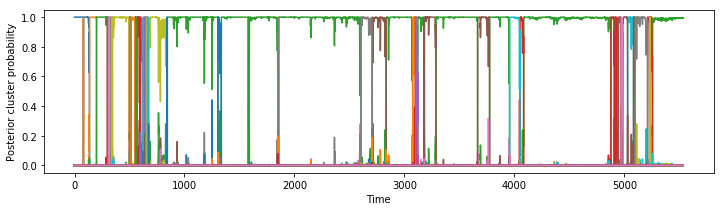

In [3]:
# import tensorflow as tf
from models import SEM, Guassian

D = np.shape(sax)[1]

f_class = Guassian
f_opts=dict()

def run_sem(X, f_class, f_opts):
    # set the parameters for the models
    _, D = X.shape

    lmda = 10**5.
    alfa = 10**-1

    # note! the likelihood function needs to be scaled with the dimensionality of the vectors
    # to compensate for the natural sharpening of the likelihood function as the dimensionality expands
    beta = np.var(sax[0:, :], axis=0) * 2.50

    Omega = {
        'lmda': lmda,  # Stickyness (prior)
        'alfa': alfa, # Concentration parameter (prior)
        'beta': beta, # Likelihood noise
        'f_class': f_class,
        'f_opts': f_opts
    }
    print 'lambda =', lmda
    print 'alpha =', alfa
    print 'beta =', beta

    sem = SEM(**Omega)
    sem.run(X, K=X.shape[0])
    
    return sem

# sem = run_sem(sax_tsne[0:250*30, :], f_class, f_opts)
sem = run_sem(sax, f_class, f_opts)

# get the MAP event models
y_hat = sem.results.e_hat


# print "Adjusted Rand Index:", r
plt.figure(figsize=(12, 3.0))
plt.plot(sem.results.post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
# tf.Session().close()

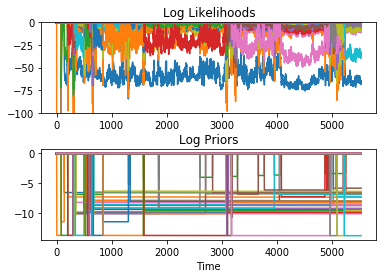

In [4]:
fig, axes = plt.subplots(2, 1)

axes[0].plot(sem.results.log_like)
# axes[0].plot(sem.results.log_like / 20)
axes[0].set_title('Log Likelihoods')
axes[0].set_ylim([-100, 0])
# plt.yscale('log')

axes[1].plot(sem.results.log_prior)
axes[1].set_title('Log Priors')
axes[1].set_xlabel('Time')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [5]:
np.sum(sem.results.pe)

3960.319573515853

In [6]:
e_hat = sem.results.e_hat
sem.results.post.shape

(5537, 5537)

0.0013584143910612223


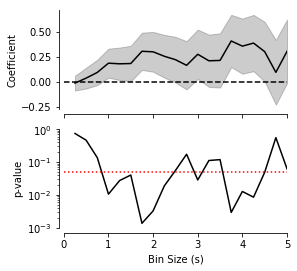

In [7]:
e_idx = np.zeros(np.shape(sem.results.post), dtype=bool)
for ii, e in enumerate(e_hat):
    e_idx[ii, e] = True
boundary_probability = 1 - sem.results.post[e_idx]

# bin the boundary probability!

bin_size = 1.0

from statsmodels.regression.linear_model import OLS


def z_score(x):
    return (x - np.mean(x)) / np.std(x)

def compare_sem_to_human(bin_size):

    frame_time = np.arange(1, len(boundary_probability) + 1) / 30.0



    index = np.arange(0, np.max(frame_time), bin_size)
    sem_binned = []
    for t in index:
        sem_binned.append(boundary_probability[(frame_time >= t) & (frame_time < (t + bin_size))].max())
    sem_binned = pd.Series(sem_binned, index=index)

    ## bin the subject data
    young_warned_sax = pd.read_csv('data/zachs_2006_young_unwarned.csv', header=-1)
    young_warned_sax.set_index(0, inplace=True)
    yw_binned = []
    for t in index:
        l = young_warned_sax[(young_warned_sax.index > t) & 
                               (young_warned_sax.index < (t + bin_size))]
        if l.empty:
            yw_binned.append(0)
        else:
            yw_binned.append(l.mean().values[0])


    yw_binned = pd.Series(np.array(yw_binned), index=index)
    
    model = OLS(z_score(sem_binned), z_score(yw_binned))

    return model.fit()
    

fig, axes = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

step_size = 0.25

bins = np.arange(step_size, 5.01, step_size)
bw = np.array([compare_sem_to_human(b).params['x1'] for b in bins])
bse = np.array([compare_sem_to_human(b).bse['x1'] for b in bins])

ax = axes[0]
ax.plot(bins, bw, color='k')
ax.fill_between(bins, bw - bse*2, bw + bse*2, alpha=0.2, color='k')
ax.axhline(0, color='k', linestyle='--')

ax.set_ylabel('Coefficient')
ax.set_xlim([0, 5])

ax = axes[1]
p = np.array([compare_sem_to_human(b).pvalues['x1'] for b in bins])
ax.plot(bins, p, color='k')
ax.axhline(0.05, linestyle=':', color='r')
ax.set_yscale('log')
ax.set_ylabel('p-value')
ax.set_xlabel('Bin Size (s)')

print np.min(p)

sns.despine(offset=5)
plt.savefig('GaussianEvents_regression.png', dpi=300, bbox_inches='tight')

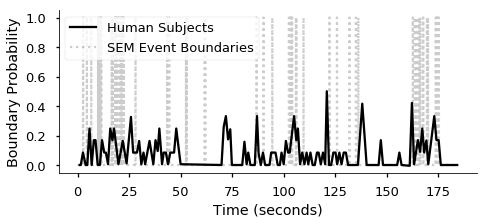

In [8]:
boundaries = y_hat[:-1] != y_hat[1:]
x = np.arange(1, len(boundaries) + 1) / 30.0


# # np.arange(np.shape(sax)[0], dtype='float') / 30.0
sns.set_context('talk')
plt.subplots(1, 1, figsize=(7.5, 3.0))
# plt.plot(np.arange(1, np.shape(sem.results.pe)[0]+1, dtype='float') / 30.0, zero_one_scale(sem.results.pe))

# young_warned_sax = pd.read_csv('zachs_2006_young_warned.csv', header=-1)
# young_warned_sax.set_index(0, inplace=True)
# plt.plot(young_warned_sax.index, young_warned_sax[1], 'r', alpha=0.5, label='Human Subjects (Young Warned)')

young_warned_sax = pd.read_csv('data/zachs_2006_young_unwarned.csv', header=-1)
young_warned_sax.set_index(0, inplace=True)
plt.plot(young_warned_sax.index, young_warned_sax[1], 'k', alpha=1.0, label='Human Subjects')

plt.plot(x, boundaries, 'k:', alpha=0.2, label='SEM Event Boundaries')

plt.ylabel('Boundary Probability')
plt.xlabel('Time (seconds)')

plt.legend(loc='upper left',)
sns.despine()

plt.savefig('GaussianEventsVsHuman.png', dpi=300)



In [12]:
sem.event_models[1].Sigma

array([[0.07114588, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04114218, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04740954, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02142345, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02722598,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.54822022]])